## H - Truncation and bounds

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

**Proposal**: A simple example of truncated marginal neural ratio estimation (TMNRE).

**Key take-away messages**: Reducing data variance with truncation helps with simulation budgets and networks learning capacity.

### Code

In [ ]:
import numpy as np
import pylab as plt
from scipy import stats
import swyft
import torch

Often we want to generate vectors whose components are drawn from different priors. This can be done with the `swyft.RectBoundSampler` object.  An example:

In [ ]:
sampler = swyft.RectBoundSampler([stats.norm(0, 1),      # Standard normal prior
                                  stats.uniform(-1, 1),  # Uniform prior on the interval [-1, 0]
                                  stats.norm(5*np.ones(10), 0.01)  # 10 parameters 5 +- 0.01
                                  ])
sampler()  # Returns a 12-dim vector

array([ 0.51449384, -0.67550162,  5.00628151,  4.99412824,  5.00132216,
        5.00506227,  4.98350209,  4.99667491,  5.00098006,  4.99940004,
        4.99808953,  5.00618935])

This object provides convient functions to sample from truncated versions of the priors.  Those have to be specified as argument `bounds`.  Bounds should have the shape $N_\text{params} \times 2$.  An example:

In [ ]:
bounds = np.array([[1., 1.1], [0.5, 0.6]])
sampler = swyft.RectBoundSampler([stats.norm(0, 1), stats.uniform(-1, 2)], bounds = bounds)
sampler()

array([1.00646544, 0.52939944])

We will use the simulator from the linear regression exercise above.  Instead of sampling with `np.random.rand`, we will however use the `RectBoundSampler`. We also will reduce the noise level.

In [ ]:
class Simulator(swyft.Simulator):
    def __init__(self, Nbins = 100, sigma = 0.01, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.y = np.linspace(-1, 1, Nbins)
        self.sigma = sigma
        self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([-1, -1, -1]), np.array([2, 2, 2])), bounds = bounds)

    def calc_m(self, z):
        m = np.ones_like(self.y)*z[0] + self.y*z[1] + self.y**2*z[2]
        return m

    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)

We now generate a mock observation $\mathbf x_0 \sim p(\mathbf x| \mathbf z_0)$ with some simple parameter vector $\mathbf z_0 = (0, 0, 0)^T$. We contrast it with random draws from the simulator, $\mathbf x \sim p(\mathbf x)$.

  0%|          | 0/100 [00:00<?, ?it/s]

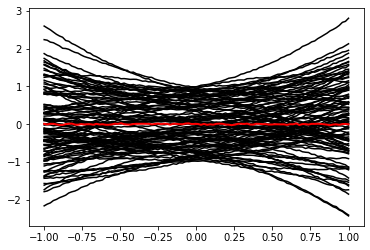

In [ ]:
sim = Simulator()
obs = sim.sample(conditions = {'z': np.array([0, 0, 0])})
samples = sim.sample(100)
for i in range(len(samples)):
  plt.plot(sim.y, samples[i]['x'], 'k')
plt.plot(sim.y, obs['x'], 'r', lw=2)

Furthermore, we use again our standard inference network with linear compression.

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(100, 10)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        f = self.lin(A['x'])
        logratios = self.logratios(f, B['z'])
        return logratios

We now define a function that performs a single "round" of simulation, training and evaluation.  As arguments, it only takes the `bounds` to use for the simulation, and the target `obs` for inference.

In [ ]:
def round(obs, bounds = None):
    sim = Simulator(bounds = bounds)
    samples = sim.sample(10000)
    dm = swyft.SwyftDataModule(samples, fractions = [0.7, 0.2, 0.1], num_workers = 3, batch_size = 64)
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 10, precision = 64)
    network = Network()
    trainer.fit(network, dm)
    prior_samples = sim.sample(N = 10000, targets = ['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (3,), threshold = 1e-6)
    return predictions, new_bounds, samples

The only new function is here `swyft.collect_rect_bounds`, which takes a collection of log ratio estimators as first argument, and then collects 1-dim bounds for the indicated parameter `z`.  The shape of z must be specified explicitly for the collection algorithm to work.

Now let's do three rounds of simulation, training, evaluation and bound determination. 

In [ ]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(3):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K
-----------------------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 110it [00:00, ?it/s]

New bounds: tensor([[-0.0910,  0.1230],
        [-0.1115,  0.0895],
        [-0.1381,  0.1340]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K
-----------------------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 110it [00:00, ?it/s]

New bounds: tensor([[-0.0141,  0.1229],
        [-0.0196,  0.0894],
        [-0.0626,  0.0423]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | lin       | Linear                 | 1.0 K 
1 | logratios | LogRatioEstimator_1dim | 54.0 K
-----------------------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.440     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 110it [00:00, ?it/s]

New bounds: tensor([[-0.0133,  0.0161],
        [-0.0196,  0.0178],
        [-0.0464,  0.0417]], dtype=torch.float64)


Now we can plot the posteriors obtained in several subsequent rounds together. Initially they are wide, then they converge to narrow posteriors with high precision in the later rounds.

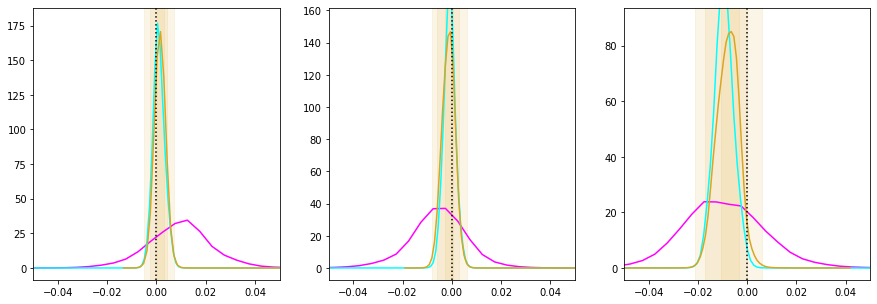

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    ax = axes[i]
    swyft.plot_1d(prediction_rounds[0], "z[%i]"%i, smooth = 1, bins = 400, contours = False, ax = ax, color='fuchsia')
    swyft.plot_1d(prediction_rounds[1], "z[%i]"%i, smooth = 1, bins = 200, contours = False, ax = ax, color='cyan')
    swyft.plot_1d(prediction_rounds[2], "z[%i]"%i, smooth = 1, bins = 100, contours = True, ax = ax, color='goldenrod')
    ax.set_xlim([-0.05, 0.05])
    ax.axvline(obs['z'][i], color='k', ls = ':')

It is also instructive to plot the training data.

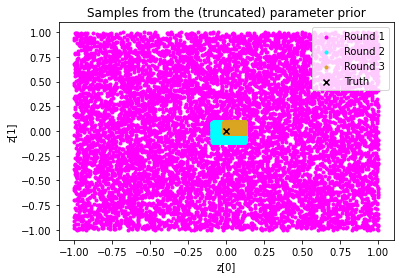

In [ ]:
plt.scatter(samples_rounds[0]['z'][:,0], samples_rounds[0]['z'][:,1], color = 'fuchsia', label = 'Round 1', marker = '.')
plt.scatter(samples_rounds[1]['z'][:,0], samples_rounds[1]['z'][:,1], color = 'cyan', label = "Round 2", marker = '.')
plt.scatter(samples_rounds[2]['z'][:,0], samples_rounds[2]['z'][:,1], color = 'goldenrod', label = 'Round 3', marker = '.')
plt.scatter(obs['z'][0], obs['z'][1], marker = 'x', color='k', label = 'Truth')
plt.legend()
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.title("Samples from the (truncated) parameter prior");

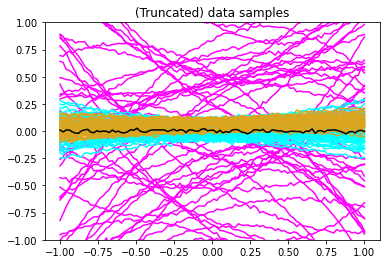

In [ ]:
for i, color in enumerate(['fuchsia', 'cyan', 'goldenrod']):
    for j in range(50):
        plt.plot(sim.y, samples_rounds[i]['x'][j], color = color)
plt.plot(sim.y, obs['x'], color = 'k')
plt.ylim([-1, 1])
plt.title("(Truncated) data samples");

### Exercises

1. How many rounds are needed for convergence in this example?

In [ ]:
# Results here

2. Lower the amount of training data per round to 3000.  Do you still achieve reasonable progress during subsequent rounds?

In [ ]:
# Results here

3. What happens if you increase the threshold in the bound routine to 1e-2?

In [ ]:
# Results here